# Проект: Статистический анализ данных
Анализ популярного сервиса аренды самокатов GoFast. 
Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.  

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:  
*без подписки*  
абонентская плата отсутствует;  
стоимость одной минуты поездки — 8 рублей;  
стоимость старта (начала поездки) — 50 рублей;  

*с подпиской Ultra*  
абонентская плата — 199 рублей в месяц;  
стоимость одной минуты поездки — 6 рублей;  
стоимость старта — бесплатно.  

В основных данных есть информация о пользователях, их поездках и подписках.   
Пользователи — users_go.csv  
user_id	уникальный идентификатор пользователя  
name	имя пользователя  
age	возраст  
city	город  
subscription_type	тип подписки (free, ultra).  

Поездки — rides_go.csv  
user_id	уникальный идентификатор пользователя  
distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)  
duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
date	дата совершения поездки.    

Подписки — subscriptions_go.csv  
subscription_type	тип подписки  
minute_price	стоимость одной минуты поездки по данной подписке  
start_ride_price	стоимость начала поездки  
subscription_fee	стоимость ежемесячного платежа.    

Изучим информацию, подготовим данные к дальнейшей работе, проведем исследовательский и статистический анализ.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
from io import BytesIO
import requests

#### Шаг 1. Загрузка данных

Для анализа предоставлены 3 файла с данными: о пользователях, поездках и тарифах. Ознакомимся с каждым из наборов данных.

In [2]:
spreadsheet_id = '1zroC8F7Q9NHafAqFeVgJkZbD1r3doqXalN3shYdobjw'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))
display(data.head(10))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [3]:
spreadsheet_id = '156pDDXRSj2rqIS-ahWE8OQzaPiur9oib3l6Ua0d5wvA'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
rides_go = pd.read_csv(BytesIO(r.content))
display(rides_go.head(10))

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [4]:
spreadsheet_id = '1mJ0TgB651NVbEJNMjuvsdT7-kEU-U2yUhvE3p-X3EzY'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
subscriptions_go = pd.read_csv(BytesIO(r.content))
display(subscriptions_go.head(10))

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Шаг 2. Предобработка данных

Проведем предобработку данных. Для этого изучим общую информацию о содержимом датафреймов.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Данные сохранены в корректных форматах и пригодны для дальнейшего анализа.
Проверим сведения на наличие дублирующих записей.

In [6]:
data.duplicated().sum()

31

Обнаружено 31 дубликат. Т.к. этот датафрейм содержит только общую информацию о пользователях, удаление дублирующих записей не повлияет негативно на дальнейший анализ.

In [7]:
data = data.drop_duplicates(subset=['user_id'], keep='first')

In [8]:
data.duplicated().sum()

0

Все записи теперь уникальны.
Проверим наличие пропусков в данных.

In [9]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Первый файл содержит чистые, уникальные данные о каждом пользователе. Пропусков нет, что говорит о качественных исходных данных для анализа.

Ознакомимся со следующим набором данных из файла о поездках пользователей и обработаем, при необходимости, дублирующие и пропущенные записи.

In [10]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Столбец с датой поездки выгружен в неподходящем формате. Исправим это и приведем данные к формату "datetime".

In [11]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

In [12]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [13]:
rides_go.duplicated().sum()

0

In [14]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

Во втором файле так же качественный набор данных, без пропусков и дублирующих сведений. 

Добавим в датафрейм столбец с порядковым номером месяца осуществления поездки для дальнейшей работы. Но, прежде нужно уточнить, за какие года содержатся данные в датафрейме.

In [15]:
rides_go['date'].dt.year.value_counts()

2021    18068
Name: date, dtype: int64

Все поездки совершены в течение одного года (2021г.). Добавим в датафрейм столбец с порядковым номером месяца:

In [16]:
rides_go['mounth'] = rides_go['date'].dt.month
display(rides_go.head(5))

,user_id,distance,duration,date,mounth
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Для подсчёта стоимости округлим до следующего целого числа продолжительность каждой поездки в каждой строке исходного датафрейма  (это условие из шага 5)

In [17]:
# каждое значение из столбца duration округляется с помощью «потолка»: 
rides_go['duration'] = np.ceil(rides_go['duration']) 
display(rides_go.head(5))

,user_id,distance,duration,date,mounth
0,1,4409.919140,26.0,2021-01-01,1
1,1,2617.592153,16.0,2021-01-18,1
2,1,754.159807,7.0,2021-04-20,4
3,1,2694.783254,19.0,2021-08-11,8
4,1,4028.687306,27.0,2021-08-28,8


In [18]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Датафреймы обработаны от дублирующих записей. Пропусков данных не обнаружено. Сведения сохранены в "рабочих" форматах. Данные готовы для дальнейшего анализа.

#### Шаг 3. Исследовательский анализ данных

На этом шаге проведем исследовательский анализ: изучим и визуализируем общую информацию о пользователях и поездках.

##### Подсчитаем частоту встречаемости городов:

In [19]:
data['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Отразим полученные данные на графике для наглядности:

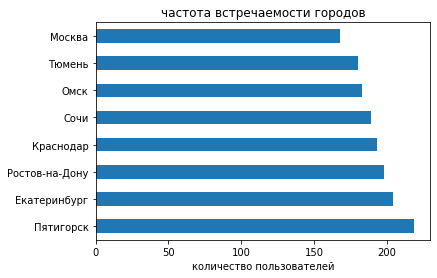

In [20]:
data['city'].value_counts().plot(kind='barh', error_kw={'ecolor':'0.8','capsize':6},alpha=1)
plt.xlabel('количество пользователей')
plt.title('частота встречаемости городов')
plt.show()

Разброс количества пользователей в городах не очень большой. Все города в среднем встречаются примерно 190 раз. Пр этом, в Пятигорске наблюдается максимальное количество пользователей из исследуемого объема сведений - более 200, а в Москве - минимум, 168 зарегистрированных любителей двухколесного транспорта.

##### Cоотношение пользователей с подпиской и без подписки

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться
без подписки  либо с подпиской Ultra. Отобразим долю каждого вида пользователей на диаграмме:

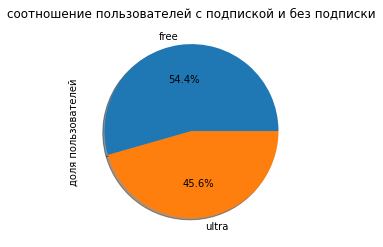

In [21]:
data['subscription_type'].value_counts().plot(kind='pie', shadow=True,autopct='%1.1f%%')
plt.title('соотношение пользователей с подпиской и без подписки')
plt.ylabel('доля пользователей')
plt.show()

Как видим, пользователи разделились практически пополам: 54,4% пользуются сервисом без подписки, а 45,6% - покупают подписку ultra. 

##### Возраст пользователей

In [22]:
data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

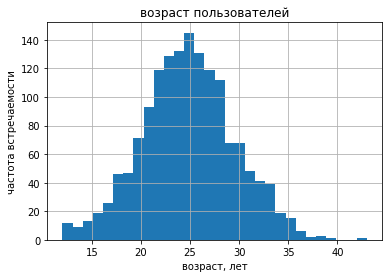

In [23]:
data['age'].hist(bins=30)
plt.title('возраст пользователей')
plt.xlabel('возраст, лет')
plt.ylabel('частота встречаемости')
plt.show()

Средний возраст пользователей шеринга самокатов - 24,9 лет, медианное значение находится на отметке 25 лет. Эти же данные отражены на графике и, действительно, пик находится на отметке в 25 лет. В целом, возраст пользователей распределен близко к нормальному: нет аномально больших или малых величин. В диапазоне от 12 до 25 лет количество пользователей увеличивается с ростом возраста, после 25 до 40 - плавно уменьшается с увеличением возраста.

##### Расстояние, которое пользователь преодолел за одну поездку

In [24]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

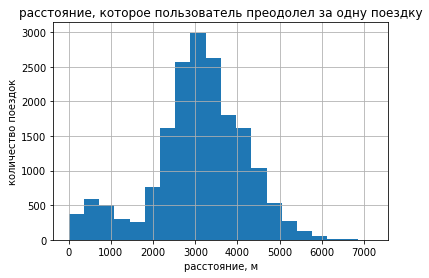

In [25]:
rides_go['distance'].hist(bins=20)
plt.title('расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('расстояние, м')
plt.ylabel('количество поездок')
plt.show()

В среднем, пользователи используют самокат на поездки около 3 км. Это подтверждает и медианное и среднее значение из датафрейма. Небольшое количество пользователей в диапазоне поездки до 1 км - это, скорее всего, те, кто хотел просто прокатиться, попробовать и для себя понять, интересен ли им этот вид транспорта или безопаснее пешком. Основная масса поездок осуществляется на расстояния от 2 до 5 км.

Если усреднить данные по каждому пользователю, то, в целом, подтвердится предыдущий вывод - средняя дистанция поездки в районе 3 км, оптимальное расстояние - от 2,5 до 3,5 км.

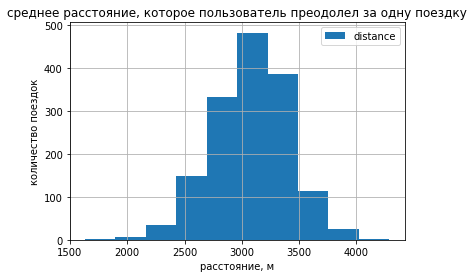

In [26]:
rides_go.pivot_table(index='user_id', values='distance', aggfunc='mean').plot(kind='hist', grid=True)
plt.title('среднее расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('расстояние, м')
plt.ylabel('количество поездок')
plt.show()

##### Продолжительность поездок

In [27]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

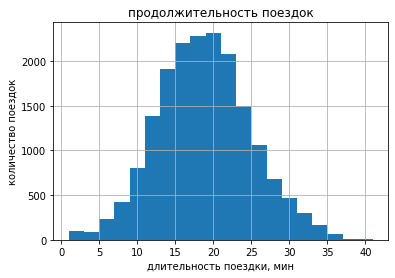

In [28]:
rides_go['duration'].hist(bins=20)
plt.title('продолжительность поездок')
plt.xlabel('длительность поездки, мин')
plt.ylabel('количество поездок')
plt.show()

Как видно на гистограмме, обычно средняя продолжительность поездки составляет примерно 18 минут. С учетом разной скорости движения, которая в большей степени зависит от опыта использования подобного транспорта, поездки занимают от 10 до 25 минут.

Рассчитаем скорость передвижения на самокатах и посмотрим, есть ли аномальные значения в данных. Для этого расстояние поездки разделим на продолжительность сессии и выведем основные описательные характеристики полученных данных.

In [29]:
(rides_go['distance']/rides_go['duration']).describe()

count    18068.000000
mean       197.376144
std        366.031230
min          0.077789
25%        132.086995
50%        166.175819
75%        208.556447
max       7211.007745
dtype: float64

Средняя скорость установилась на отметке в 197 м/мин. Медиана немного меньше = 166 м/мин. Если исходить из представленных ранее выводом, медианное значение лучше описывает реальную скорость: для преодоления расстояния в 3000 м (средняя дистанция поездки) за 18 минут (средняя продолжительность)  нужно ехать со скорость, близкой к медианной - 18х166=2988 м.  
Максимальная отметка достигает 7211 м/мин - это аномальное значение, такая скорость нереальна для исследуемого вида транспорта.   
Нужно выяснить причину появления таких аномалий для их устранения. Значения оставим без изменения.

#### Шаг 4. Объединение данных

Для дальнейшей работы объединим сведения из 3х файлов в единую таблицу.

In [30]:
all_data = data.merge(rides_go, on='user_id', how='right')
all_data

,user_id,name,age,city,subscription_type,distance,duration,date,mounth
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11


In [31]:
all_data = all_data.merge(subscriptions_go, on='subscription_type', how='left')
all_data

,user_id,name,age,city,subscription_type,distance,duration,date,mounth,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [32]:
len(all_data)

18068

Исходный датафрейм, к которому присоединяли остальные данные, был наибольшим, и содержал 18068 строк. Полученная таблица содержит все исходные данные + присоединенные.  
Проверим обновленную таблицу на наличие пропусков.

In [33]:
all_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
mounth               0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Все ячейки корректно перенеслись и заполнились. Благодаря качественным исходным данным дальнейшая обработка не доставляет неожиданных сюрпризов.

Из объединенной таблицы сделаем два датафрейма:  
c данными о пользователях без подписки;  
с данными о пользователях с подпиской.

In [34]:
free_data = all_data.query('subscription_type == "free"')
free_data.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,mounth,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0


In [35]:
len(free_data)

11568

In [36]:
ultra_data = all_data.query('subscription_type == "ultra"')
ultra_data.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,mounth,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [37]:
len(ultra_data)

6500

Оценим, какое расстояние поездки характерно для обоих категорий пользователей: с подпиской и без нее. Для этого выведем сведения о каждом датасете поочередно:

In [38]:
free_data['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [39]:
ultra_data['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

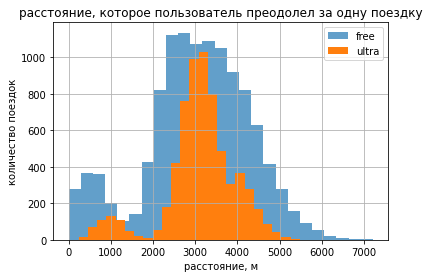

In [40]:
ax = free_data.plot(kind='hist',
                   y = 'distance',
                   bins=25, label = 'free',
                   alpha=0.7)
ultra_data.plot(kind='hist',
                   y = 'distance',
                   bins=25, label = 'ultra',
               ax = ax, grid=True)
plt.xlabel('расстояние, м')
plt.ylabel('количество поездок')
plt.title('расстояние, которое пользователь преодолел за одну поездку')
plt.show()

Пользователи с подпиской - более узкая категория, они используют самокат для поездок от 2,5 до 3,7 км, реже до 5 км. Стандартное отклонение зафиксировалось на отметке в 837 м против 1246 м для пользователей без подписки. Они (free) используют самокат для большего диапазона расстояний поездки - от 2 до почти 5 км. При этом, средние и медианные значения расстояния у обеих групп приблизительно равны.

Проведем анализ времени использования транспорта обеими категориями пользователей. Для этого так же выведем общие сведения о времени поездки и построим график.

In [41]:
free_data['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [42]:
ultra_data['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

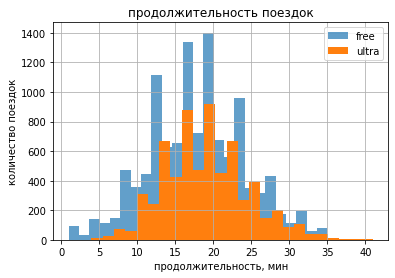

In [43]:
ax = free_data.plot(kind='hist',
                   y = 'duration',
                   bins=25, label = 'free',
                   alpha=0.7)
ultra_data.plot(kind='hist',
                   y = 'duration',
                   bins=25, label = 'ultra',
               ax = ax, grid=True)
plt.xlabel('продолжительность, мин')
plt.ylabel('количество поездок')
plt.title('продолжительность поездок')
plt.show()

Так же, как и с расстоянием, мы можем видеть похожее поведение пользователей обеих категорий. Наличие подписки не оказывает особого влияния на продолжительность поездки. Количество пользователей "free" больше, просто потому что эта категория, в принципе, немного больше. Но, само распределение на графике продолжительности поездки близко к нормальному для обеих категорий. Средняя и медианная продолжительность разнится в пределах 1 минуты, что не очень существенно и объясняется многими внешними факторами, влияющими на длительность поездки (наличие светофоров на маршруте, пешеходных переходов, специальных выделенных полос и т.п.)

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [44]:
all_data_pivot = all_data.pivot_table(index=('user_id', 'mounth'), values=['distance', 'duration', 'minute_price', 
                                    'start_ride_price', 'subscription_fee'], 
                                    aggfunc=({'distance':{'count', 'sum'}, 'duration':'sum',  'minute_price':'mean',
                                              'start_ride_price':'mean','subscription_fee':'mean',}))
all_data_pivot

distance               duration minute_price start_ride_price  \
                  count           sum      sum         mean             mean   
user_id mounth                                                                 
1       1             2   7027.511294     42.0            6                0   
        4             1    754.159807      7.0            6                0   
        8             2   6723.470560     46.0            6                0   
        10            2   5809.911100     32.0            6                0   
        11            3   7003.499363     56.0            6                0   
...                 ...           ...      ...          ...              ...   
1534    6             2   3409.468534     26.0            8               50   
        8             2   7622.453034     48.0            8               50   
        9             1   4928.173852     23.0            8               50   
        11            4  13350.015305     78.0            8               50   
        12            1   2371.711192     16.0            8               50   

               subscription_fee  
                           mean  
user_id mounth                   
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199  
...                         ...  
1534    6                     0  
        8                     0  
        9                     0  
        11                    0  
        12                    0  

[11331 rows x 6 columns]

In [45]:
#отредактируем названия столбцов 
all_data_pivot.columns = ['count', 'distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee']
all_data_pivot.head(10)

count      distance  duration  minute_price  start_ride_price  \
user_id mounth                                                                  
1       1           2   7027.511294      42.0             6                 0   
        4           1    754.159807       7.0             6                 0   
        8           2   6723.470560      46.0             6                 0   
        10          2   5809.911100      32.0             6                 0   
        11          3   7003.499363      56.0             6                 0   
        12          2   6751.629942      28.0             6                 0   
2       3           3  10187.723006      63.0             6                 0   
        4           2   6164.381824      40.0             6                 0   
        6           1   3255.338202      14.0             6                 0   
        7           2   6780.722964      48.0             6                 0   

                subscription_fee  
user_id mounth                    
1       1                    199  
        4                    199  
        8                    199  
        10                   199  
        11                   199  
        12                   199  
2       3                    199  
        4                    199  
        6                    199  
        7                    199

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки.   
Помесячная выручка считается по формуле: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [46]:
all_data_pivot['revenue'] = (
    all_data_pivot['start_ride_price']*all_data_pivot['count'])+(
    all_data_pivot['minute_price']*all_data_pivot['duration'])+(
    all_data_pivot['subscription_fee'])
all_data_pivot

count      distance  duration  minute_price  start_ride_price  \
user_id mounth                                                                  
1       1           2   7027.511294      42.0             6                 0   
        4           1    754.159807       7.0             6                 0   
        8           2   6723.470560      46.0             6                 0   
        10          2   5809.911100      32.0             6                 0   
        11          3   7003.499363      56.0             6                 0   
...               ...           ...       ...           ...               ...   
1534    6           2   3409.468534      26.0             8                50   
        8           2   7622.453034      48.0             8                50   
        9           1   4928.173852      23.0             8                50   
        11          4  13350.015305      78.0             8                50   
        12          1   2371.711192      16.0             8                50   

                subscription_fee  revenue  
user_id mounth                             
1       1                    199    451.0  
        4                    199    241.0  
        8                    199    475.0  
        10                   199    391.0  
        11                   199    535.0  
...                          ...      ...  
1534    6                      0    308.0  
        8                      0    484.0  
        9                      0    234.0  
        11                     0    824.0  
        12                     0    178.0  

[11331 rows x 7 columns]

In [47]:
all_revenue = all_data_pivot.pivot_table(index=('mounth'), values='revenue', aggfunc='sum')
all_revenue

,revenue
mounth,
1,337958.0
2,290428.0
3,329822.0
4,322916.0
5,337265.0
6,335978.0
7,328504.0
8,325650.0
9,323037.0


Отобразим на графике выручку по месяцам:

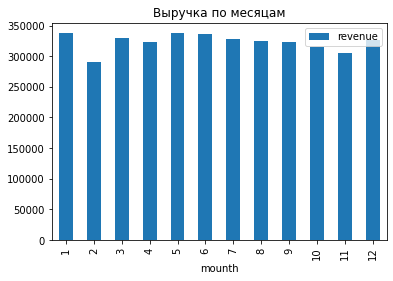

In [48]:
all_revenue.plot(kind='bar')
plt.title('Выручка по месяцам')
plt.show()

Как видно на графике, резких скачков или провалов не наблюдается. Прокат приносит стабильный доход от месяца к месяцу. Возможны небольшие колебания в зависимости от сезона или, возможно, погодных условий.

In [49]:
print('Всего выручка составила:', all_data_pivot['revenue'].sum().round(0), 'рублей')

Всего выручка составила: 3878641.0 рублей


#### Шаг 6. Проверка гипотез

6.1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу.

Выдвинем 2 гипотезы:  
Н0: Средняя продолжительность поездок с подпиской ultra и без нее равна  
Н1: Средняя продолжительность поездок с подпиской ultra больше продолжительности поездок без подписок (free)

In [50]:
alpha = 0.05
results = st.ttest_ind(ultra_data['duration'], free_data['duration'], alternative='greater')
print(f'p_value: {results.pvalue}')
if results.pvalue<alpha:
    print('отвергаем нулевую гипотезу Н0')
else:
    print('нет оснований отвергать Н0')

p_value: 2.4959453720736625e-34
отвергаем нулевую гипотезу Н0


Гипотеза о равенстве продолжительности поездок для пользователей с подпиской и без отвергнута. Есть основания утверждать, что средняя продолжительность поездки с подпиской больше продолжительности поездок без подписки (при установленном уровне значимости в 5 %). При этом, на представленных ранее графиках этого практически не заметно, но, все же, есть небольшое смещение в сторону большей продолжительности.

6.2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?   
Выдвинем гипотезы:  
Н0: среднее расстояние, которое проезжают пользователи с подпиской, равно 3130 м (оптимальное с точки зрения износа самоката);  
Н1: среднее расстояние, которое проезжают пользователи с подпиской, более 3130 м.

In [51]:
distance = 3130
alpha = 0.05
results = st.ttest_1samp(ultra_data['distance'], distance, alternative='greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [52]:
ultra_data['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров с точки зрения износа самоката. Подтверждение проведенным ранее исследованиям. Действительно, среднее расстояние, которое проезжают пользователи с подпиской, немного меньше. И это оказывает положительное влияние на износ техники - самокаты не работают "на износ".

6.3. Определим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.  
Выдвинем гипотезы:  

Н0: месячная средняя выручка от пользователей с подпиской равна месячной средней выручке от пользователей без подписки.  
Н1: месячная средняя выручка от пользователей с подпиской больше месячной средней выручки от пользователей без подписки.  

Проверим гипотезы, используем данные о выручке с подпиской и без подписки.

In [53]:
results = st.ttest_ind(
    all_data_pivot.loc[all_data_pivot['subscription_fee'] > 0, 'revenue'], 
    all_data_pivot.loc[all_data_pivot['subscription_fee'] == 0, 'revenue'], 
    equal_var=True, 
    alternative='greater')
print(results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, есть основания утверждать, что средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки.

6.4. Для решения поставленной задачи нужно использовать метод scipy.stats.ttest_rel() - для проверки гипотез парных выборок.
Предполагаемые выборки - парные, - это такие выборки, которые претерпели изменения. Некоторая переменная измеряется дважды (количество обращений до обновления и после него) для одних и тех же объектов (пользователь) и выборки имеют одинаковые размеры.  При этом, нужно выдвигать одностороннюю гипотезу, т.к. техподдержку интересует только вопрос "снизилось ли?", а не "изменилось в какую-либо сторону".

#### По итогам проведенного анализа можно сделать следующие выводы:  
1. Рассмотрены данные о пользователях сервиса проката самокатов в разных городах России, продолжительность их поездок и порядок пользования сервисом (с подпиской и без).
2. В целом, исходные данные максимально качественные, в них отсутствуют пропуски, не корректно заполненные данные. Было обнаружено незначительное количество дублирующих записей о пользователях. Эти данные были удалены без потери качества дальнейшего исследования.  
3. Проведен исследовательский анализ.   
  3.1. Сервис проката представлен в 8 городах. При этом, пользователи приблизительно одинаково пользуются сервисом в исследуемых городах. Разброс данных незначительный. Наиболее часто в данных встречается г.Пятигорск (более 200 раз), наименьшее число упоминаний о г.Москве (168).  
  3.2. Пользователей, оформивших подписку для аренды самокатов, немного меньше, чем пользующихся сервисом без нее (45,6% против 54,4%).
  3.3. Средний возраст активных пользователей - 25 лет. Эту же отметку подтверждает и медианное значение сведений о возрасте арендаторов. Так же наблюдается активный интерес пользователей и младше, и более старшего возраста. Распределение пользователей по возрату близко к нормальному.  
  3.4. В основном, самокаты арендуют для поездок на расстояние около 3-3,5 км.  
  3.5. При этом, продолжительность такой поездки составляет около 18 минут.   
4. Изучены поведенческие данные о раастояниях поездок и их продолжительности отдельно для категорий с подпиской и без нее.  
Наличие подписки не оказывает особого влияния на продолжительность поездки, следовательно, и на ее расстояние. Средняя и медианная продолжительность разнится в пределах 1 минуты, что не очень существенно и объясняется многими внешними факторами, влияющими на длительность поездки (наличие светофоров на маршруте, пешеходных переходов, специальных выделенных полос и т.п.).  
Пользователи с подпиской используют самокат для поездок от 2,5 до 3,7 км, реже до 5 км. Для пользователей без подписки диапазон расстояний поездки - от 2 до почти 5 км. При этом, средние и медианные значения расстояния у обеих групп приблизительно равны.  
5. Выдвинуты несколько гипотез.  
  5.1. Тратят ли пользователи с подпиской больше времени на поездки? - Гипотеза о равенстве продолжительности поездок для пользователей с подпиской и без отвергнута. Есть основания утверждать, что средняя продолжительность поездки с подпиской больше продолжительности поездок без подписки.  
  5.2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? - гипотеза не отвергнута. Среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров с точки зрения износа самоката.  
  5.3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? -  гипотеза отвергнута, есть основания утверждать, что средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки.  
  Следовательно, на основании проведенного анализа, считаю, что пользователи с оформленной подпиской ultra приносят бизнесу большую выручку, нежели вторая категория (free).